# 뉴스 요약봇

## 목차

## 1. Set-up

 - 패키지들을 import하는 작업
 
## 2. 데이터 불러오기

 - 데이터를 가져온 뒤 샘플 확인

## 3. 데이터 전처리

 - 데이터 정리
 - 훈련 데이터와 테스트 데이터 나누기
 - 정수 인코딩

## 4. 모델 설계하기

 - 인코더, 디코더 설계
 - 어텐션 메커니즘 설계

## 5. 인퍼런스 모델 구현


## 6. 모델 테스트하기


## 7. 추출적 요약

 - summarize 사용

## 8. 회고

---

# 1. Set up

### 라이브러리 버전 확인

In [31]:
!pip install summa

from importlib.metadata import version
import nltk
import tensorflow
import summa
import pandas

print(nltk.__version__)
print(tensorflow.__version__)
print(pandas.__version__)
print(version('summa'))

3.6.5
2.6.0
1.3.3
1.2.0


# 2. 데이터 불러오기

In [32]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import AdditiveAttention

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

### 데이터 샘플 확인

In [4]:
data.sample(10)

,headlines,text
68678,Delhi boy builds mini-cooler using idea from D...,A 13-year-old boy from ragpicker's family in D...
22671,70-yr-old man dies as toilet wall collapses at...,A 70-year-old man was crushed to death after a...
42270,1st non-stop flight from Australia to UK lands,The first regularly scheduled non-stop flight ...
1859,Apple spends $150 million a year on United Air...,A leaked internal United Airlines promotional ...
2230,Will 'devastate' Turkey economically if it att...,"US President Donald Trump has threatened to ""d..."
17833,Investors lose Ã¢ÂÂ¹4 trillion in 2 days as S...,"Investors' wealth, measured in terms of all BS..."
92767,UP police constable killed by female colleague,A police constable was allegedly killed by a f...
15038,Pakistan stamp uses pic of Indians protesting ...,A picture of Kashmiri Pandits protesting again...
88782,Baahubali 2 deserves every bit of hype and suc...,Actor Akshay Kumar took to Twitter to praise B...
44046,"Shami's wife attacks journalists in Kolkata, b...",Cricketer Mohammad Shami's wife Hasin Jahan at...


# 3. 데이터 전처리

### 데이터 정리하기

---

### 중복 샘플 배제

In [5]:
print('text 열에서 중복을 배제 샘플의 수 :', data['text'].nunique())
print('headlines 열에서 중복을 배제 샘플의 수 :', data['headlines'].nunique())

text 열에서 중복을 배제 샘플의 수 : 98360
headlines 열에서 중복을 배제 샘플의 수 : 98280


### 텍스트 정규화 작업

In [6]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


### 데이터 전처리 함수 및 불용어 제거

In [7]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens



- Abstractive한 문장 요약 결과문이 자연스러운 문장이 되려면 Headline에는 불용어가 남아있는 것이 좋기에 Text 전처리에서만 제거하고 문장 길이가 짧은 Headline은 불용어 미제거

---

### 전처리 전, 후의 결과를 확인하기 위해서 임의의 text와 Headline를 만들어 함수를 호출

In [78]:
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_headline = 'Great way to start (or finish) the day!!!'

print("text: ", preprocess_sentence(temp_text))
print("headline:", preprocess_sentence(temp_summary, False))  # 불용어를 제거하지 않습니다.

text:  everything bought great infact ordered twice third ordered wasfor mother father
headline: great way to start the day


### tqdm을 주어 진행 상태를 나타낸 후

### Text 데이터에 대한 전처리 진행

In [9]:
from tqdm import tqdm # 진행 상태를 나타내는 프로그레스바를 위한 라이브러리

# 전체 Text 데이터에 대한 전처리
clean_text = []

# tqdm을 사용하여 진행 상태를 나타내는 프로그레스바를 추가
for s in tqdm(data['text']):
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
print("Text 전처리 후 결과: ", clean_text[:5])

100%|██████████| 98401/98401 [09:41<00:00, 169.22it/s]

Text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

### headline도 같이 진행(불용어 미제거)

In [10]:
from tqdm import tqdm # 진행 상태를 나타내는 프로그레스바를 위한 라이브러리

# 전체 Summary 데이터에 대한 전처리
clean_headlines = []

# tqdm을 사용하여 진행 상태를 나타내는 프로그레스바를 추가
for s in tqdm(data['headlines']):
    clean_headlines.append(preprocess_sentence(s, False))

# 전처리 후 출력
print("Summary 전처리 후 결과: ", clean_headlines[:5])

100%|██████████| 98401/98401 [00:17<00:00, 5741.58it/s]

Summary 전처리 후 결과:  ['upgrad learner switches to career in ml al with salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'have known hirani for yrs what if metoo claims are not true sonam']


### 전처리 후 Empty 샘플이 있나 확인

In [11]:
data['text'] = clean_text
data['headlines'] = clean_headlines

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

### Null 값이 있나 확인

In [12]:
data.isnull().sum()

headlines    0
text         0
dtype: int64

## 샘플 최대 길이 정하기

### Text와 headlines의 최소, 최대, 평균 길이를 구하고 또한 길이 분포를 시각화

text 최소 길이 : 1
text 최대 길이 : 60
text 평균 길이 : 35.09983638377659
headlines 최소 길이 : 1
headlines 최대 길이 : 16
headlines 평균 길이 : 9.299651426306644


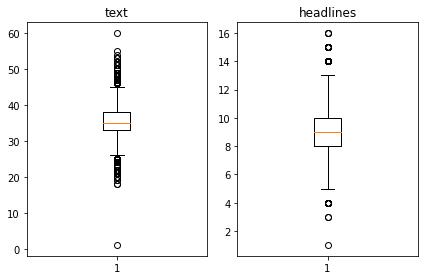

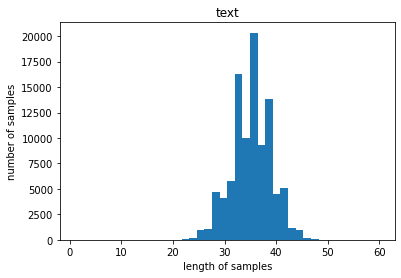

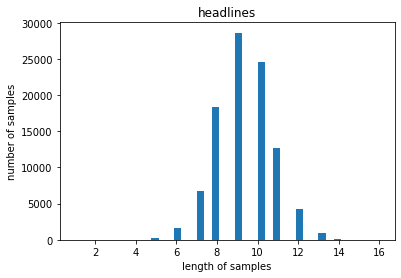

In [79]:
text_len = [len(s.split()) for s in data['text']]
summary_len = [len(s.split()) for s in data['headlines']]

print('text 최소 길이 : {}'.format(np.min(text_len)))
print('text 최대 길이 : {}'.format(np.max(text_len)))
print('text 평균 길이 : {}'.format(np.mean(text_len)))
print('headlines 최소 길이 : {}'.format(np.min(summary_len)))
print('headlines 최대 길이 : {}'.format(np.max(summary_len)))
print('headlines 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('text')
plt.subplot(1,2,2)
plt.boxplot(summary_len)
plt.title('headlines')
plt.tight_layout()
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('headlines')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

 - text 최대 길이 : 60
 - headlines 최대 길이 : 16
 
 ### 이 정보를 통해 임의로 Text와 Headline의 길이를 정함
 
 ### 시작 토큰과 종료 토큰 입력

In [14]:
text_max_len = 40
summary_max_len = 12
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform c...,sostoken delhi techie wins free food from swig...,delhi techie wins free food from swiggy for on...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
4,have known hirani for yrs what if metoo claims...,speaking sexual harassment allegations rajkuma...,sostoken have known hirani for yrs what if met...,have known hirani for yrs what if metoo claims...


### 인코더의 입력, 디코더의 입력과 레이블을 각각 다시 Numpy 타입으로 저장

In [15]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

### encoder_input과 크기와 형태가 같은 순서가 섞인 정수 시퀀스를 생성

In [16]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[67655 78869 53311 ...  4968 85147 33638]


### 다시 데이터의 샘플 순서를 정의해 섞음

In [17]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

### 섞인 데이터를 8:2의 비율로 훈련 데이터와 테스트 데이터로 분리

In [19]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 19680


 - 0.2를 곱해 테스트 데이터의 크기 정의

---

### 이렇게 정의한 테스트 데이터의 개수를 이용해 전체 데이터를 양분

In [20]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('train 데이터의 개수 :', len(encoder_input_train))
print('train 레이블의 개수 :', len(decoder_input_train))
print('test 데이터의 개수 :', len(encoder_input_test))
print('test 레이블의 개수 :', len(decoder_input_test))

train 데이터의 개수 : 78721
train 레이블의 개수 : 78721
test 데이터의 개수 : 19680
test 레이블의 개수 : 19680


## 단어 집합 만들기 및 정수 인코딩

### 입력된 훈련 데이터로부터 단어 집합

In [21]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

### 등장 빈도수가 7회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인

In [22]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 69619
등장 빈도가 6번 이하인 희귀 단어의 수: 47452
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 22167
단어 집합에서 희귀 단어의 비율: 68.15955414470187
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.4901708339349122


###  등장 빈도가 6회 이하인 단어들은 정수 인코딩 과정에서 빼고, 훈련 데이터에서 제거

In [23]:
src_vocab = 21000
src_tokenizer = Tokenizer(num_words=src_vocab)
src_tokenizer.fit_on_texts(encoder_input_train)

---

 -  texts_to_sequences()는 생성된 단어 집합에 기반하여 입력으로 주어진 텍스트 데이터의 단어들을 모두 정수로 변환하는 정수 인코딩을 수행 
 
 - 현재 단어 집합의 크기를 20,000으로 제한 
 
 - 20,000이 넘는 숫자들은 정수 인코딩 후에는 데이터에 존재하지 않음.

In [24]:
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train)
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[359, 48, 14, 3303, 2870, 61, 1281, 901, 6255, 75, 9133, 511, 461, 1689, 9134, 3771, 182, 126, 4332, 8277, 260, 550, 229, 1, 359, 2100, 39, 5607, 12548, 146], [2, 53, 40, 1902, 1974, 2093, 620, 162, 841, 4399, 8, 2067, 57, 9, 79, 11572, 47, 56, 1998, 60, 143, 21, 2033, 4944, 120, 110, 8037, 1974, 8278, 6632, 6557, 5996, 53, 18, 188], [463, 9643, 435, 3, 13, 2339, 296, 2799, 72, 284, 2696, 600, 161, 377, 2203, 11573, 91, 86, 5294, 12952, 72, 324, 7, 385, 2086, 19436, 435, 1507, 3108, 9300, 7373, 72, 298, 722, 1301]]


###  케라스의 토크나이저를 사용하여 decoder_input_train을 입력으로 전체 단어 집합과 각 단어에 대한 빈도수를 계산

In [25]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

### 등장 빈도수가 6회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인

In [26]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 30088
등장 빈도가 5번 이하인 희귀 단어의 수: 19689
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10399
단어 집합에서 희귀 단어의 비율: 65.43804839138528
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.656990912947816


### 등장 빈도가 5회 이하인 단어들은 정수 인코딩 과정에서 빼고, 훈련 데이터에서 제거

In [27]:
tar_vocab = 10000
tar_tokenizer = Tokenizer(num_words=tar_vocab)
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train)
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 349, 36, 1466, 726, 6, 55, 3787, 4, 326], [1, 8, 67, 2231, 1657, 3181, 1347, 6476, 126, 17, 5016, 24], [1, 1102, 1313, 355, 501, 3505, 48, 402, 7, 227], [1, 47, 23, 10, 259, 71, 92, 333, 2520, 7, 5669, 3, 5017], [1, 2144, 1869, 519, 3, 10, 1193, 3591, 807, 25, 4, 691]]
target
decoder  [[349, 36, 1466, 726, 6, 55, 3787, 4, 326, 2], [8, 67, 2231, 1657, 3181, 1347, 6476, 126, 17, 5016, 24, 2], [1102, 1313, 355, 501, 3505, 48, 402, 7, 227, 2], [47, 23, 10, 259, 71, 92, 333, 2520, 7, 5669, 3, 5017, 2], [2144, 1869, 519, 3, 10, 1193, 3591, 807, 25, 4, 691, 2]]


## 패딩하기

In [28]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=summary_max_len, padding='post')

# 4. 모델 설계

### endoder 설계

In [33]:
embedding_dim = 128
hidden_size = 256

encoder_inputs = Input(shape=(text_max_len,))
print(encoder_inputs)
# encoder 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# encoder LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# encoder LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# encoder LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_sequences=False, return_state=True ,dropout = 0.4)
encoder_outputs, state_h, state_c = encoder_lstm2(encoder_output2)

KerasTensor(type_spec=TensorSpec(shape=(None, 40), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")


### decoder 설계

In [34]:
decoder_inputs = Input(shape=(None,))

# decoder 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# decoder LSTM
# decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

# decoder 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 40, 128)      2688000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 40, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

## 어텐션 메커니즘

### 어텐션 메커니즘을 수행하는 어텐션 함수를 설계하는 것은 또 다른 새로운 신경망을 설계해야 한다는 뜻

 - 어텐션 층을 만들고, 위에서 설계한 디코더의 출력층을 수정

In [35]:
attn_layer = AdditiveAttention(name='attention_layer')

# encoder, decoder 모든 time step의 hidden state를 attention 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# attention 결과와 decoder hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# decoder 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 40, 128)      2688000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 40, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

### 모델 훈련

In [36]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
308/308 [==============================] - 36s 93ms/step - loss: 5.6460 - val_loss: 5.2232
Epoch 2/50
308/308 [==============================] - 28s 90ms/step - loss: 5.0512 - val_loss: 4.8307
Epoch 3/50
308/308 [==============================] - 28s 91ms/step - loss: 4.7144 - val_loss: 4.5759
Epoch 4/50
308/308 [==============================] - 29s 93ms/step - loss: 4.4603 - val_loss: 4.3897
Epoch 5/50
308/308 [==============================] - 29s 94ms/step - loss: 4.2550 - val_loss: 4.2595
Epoch 6/50
308/308 [==============================] - 29s 95ms/step - loss: 4.0878 - val_loss: 4.1460
Epoch 7/50
308/308 [==============================] - 30s 96ms/step - loss: 3.9439 - val_loss: 4.0561
Epoch 8/50
308/308 [==============================] - 30s 97ms/step - loss: 3.8160 - val_loss: 3.9854
Epoch 9/50
308/308 [==============================] - 30s 97ms/step - loss: 3.7007 - val_loss: 3.9271
Epoch 10/50
308/308 [==============================] - 30s 97ms/step - loss: 3.598

### 훈련 데이터의 손실과 검증 데이터의 손실이 줄어드는 과정을 시각화

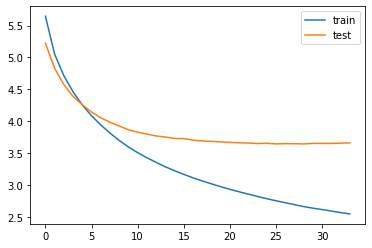

In [37]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

# 5. 인퍼런스 모델 구현

### 테스트 단계에서는 정수 인덱스 행렬로 존재하던 텍스트 데이터를 실제 데이터로 복원해야 하므로, 필요한 3개의 사전을 아래와 같이 미리 준비

In [38]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

 - 인퍼런스 단계에서는 만들어야 할 문장의 길이만큼 디코더가 반복 구조로 동작해야 하기 때문에 부득이하게 인퍼런스를 위한 모델 설계를 별도로로 해야함. 
 - 이때는 인코더 모델과 디코더 모델을 분리해서 설계

In [40]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

### 어텐션 메커니즘을 사용하는 출력층 설계

In [41]:
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# dscoder 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat)

# 최종 decoder 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

### 인퍼런스 단계에서 단어 시퀀스를 완성하는 함수

In [42]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

# 6. 모델 테스트

--- 

 - Text의 정수 시퀀스에서는 패딩을 위해 사용되는 숫자 0을 제외하고 Headlines의 정수 시퀀스에서는 숫자 0, 시작 토큰의 인덱스, 종료 토큰의 인덱스를 출력에서 제외하도록 만듦.

In [43]:
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

In [45]:
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0 and tar_index_to_word[i]!='sostoken'):
            temp = temp + tar_index_to_word[i]+' '
    return temp

### 테스트 데이터 약 50개의 샘플에 대해서 실제 요약과 예측된 요약을 비교

In [46]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("추상 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : grace bay beach islands topped travellers choice beach awards beach brazil beach cuba placed second third respectively beach goa placed th list indian beach top 
실제 요약 : grace bay beach named world best goa in top 
추상 요약 :  paris tower festival of the year


원문 : study conducted reuters claims people stream video content netflix someone else account leads estimated crore losses company analyst also predicted netflix could lose crore revenue due reason 
실제 요약 : netflix loses cr because of password sharing study 
추상 요약 :  hackers are not paid for sale of money in wood


원문 : first look poster govinda starrer rangeela raja unveiled seen double role portraying four distinct characters film govinda whose roles inspired lives vijay mallya baba ramdev collaborating pahlaj nihalani rangeela raja years 
실제 요약 : first look poster of govinda starrer raja out 
추상 요약 :  poster of unveiled on upcoming film unveiled


원문 : state bank india chairperson arundhati bhattacharya reportedly offered po

추상 요약 :  madhya pradesh cm naidu to give up life to death


원문 : around petrol cng pumps maharashtra decided stay shut sundays may also decided work single day shifts pm may petrol pump association cited salary related issues selling fuel losses low operating margins reasons shutdown 
실제 요약 : maha petrol pumps to stay shut on from may 
추상 요약 :  maha govt to shut down petrol pumps in maharashtra


원문 : technology giant apple acquired danish machine learning startup around million last year december startup previously named visual effects company applies machine learning image video editing apple recently acquired us based startup manufactures lenses augmented reality glasses 
실제 요약 : apple acquired danish startup for mn in 
추상 요약 :  apple acquires startup for million


원문 : australia south africa played shortest ever completed test got hours minutes february interestingly match spread three playing days due bad weather south africa dismissed match saw lowest aggregate history complete t

추상 요약 :  us teen convicted of spying for spying


원문 : per reports income tax appellate tribunal asked actress priyanka chopra include lakh watch lakh toyota car received gifts taxable income priyanka reportedly shown watch car gifts companies order said cover four years financial year onwards 
실제 요약 : priyanka asked to pay tax for gifts like watch report 
추상 요약 :  priyanka chopra invests lakh in maharashtra


원문 : arrived india two day visit thursday received external affairs minister sushma swaraj visit likely focus two countries signing billion deal india procure russia advanced long range surface air missile defence system putin pm narendra modi also discuss key global issues 
실제 요약 : russian prez vladimir putin arrives in india for day visit 
추상 요약 :  swaraj assures swaraj to visit kartarpur corridor


원문 : north korea agreed important prevent war united nations envoy jeffrey recently visited reclusive nation said wednesday un diplomat added urged north korea signal prepared consi

#### 잘된 점:

 - 원문의 주요 내용을 포착하려고 노력함:  예를 들어, "russian prez vladimir putin arrives in india for day visit"와 같은 요약은 원문의 핵심 내용을 정확하게 전달해주고 있음.
 - 복잡한 원문의 내용을 간결하게 표현하여 주요 정보를 제공함: 예를 들어, "attacks convict sues us govt over torture in jail"은 원문의 주요 포인트를 간결하게 전달.

#### 잘 안된 점:

 - 원문의 내용과 관련이 없거나 잘못된 정보를 포함하고 있음: 예를 들어, "chin|ese students to get out of"나 "trump saudi arabia declares victory in us"와 같은 요약은 원문의 내용을 정확하게 반영하지 않음
 - 중복된 단어나 문장 구조를 포함하고 있어, 내용 전달에 혼동을 줌: 예를 들어, "china warns huawei cfo over huawei cfo over huawei cfo"와 같은 요약은 중복된 표현이 있음

---

# 7. 추출적 요약 활용

In [66]:
from summa.summarizer import summarize

def textSummary(text) :
    text_preprocess = preprocess_sentence(text)
    text_preprocess = src_tokenizer.texts_to_sequences([text])
    text_preprocess = pad_sequences(text_preprocess, maxlen=text_max_len, padding='post')
    summa = decode_sequence(text_preprocess)
    return summa


# 예제
print("원문 :", data['text'][0])
print("실제 요약 :", data['headlines'][0])
print("추상 요약 :", textSummary(data['text'][0]))
print("추출 요약 :", summarize(data['text'][0], ratio=0.5))

원문 : saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers
실제 요약 : upgrad learner switches to career in ml al with salary hike
추상 요약 :  upgrad hires ai to upgrad with ai program
추출 요약 : 


 - 추출 요약이 안나온 이유

#### 위에서 주어진 원문은 짧기 때문에 추출 요약이 잘 안나올 가능성이 있음

#### 내부 알고리즘의 판단으로 중요하다고 생각하는 단어가 없기 때문에 요약이 안됐을 가능성이 있음(추출 요약은 원문의 단어에서 추출하기에)

#### 전처리를 하지 않은 원본 데이터일 경우 추출 요약이 될 가능성이 있음

---

### 3번을 가정으로 원본 데이터 사용

In [64]:
data_01 = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [76]:
for i in range(80, 100):
    print("원문 :", data_01['text'][i])
    print("실제 요약 :", data_01['headlines'][i])
    print("추상 요약 :", textSummary(data_01['text'][i]))
    print("추출 요약 :", summarize(data_01['text'][i], ratio=0.4))
    print('-'*50)
    print('\n')

원문 : Retired Justice Srikrishna's enquiry panel has found that ex-CEO Chanda Kochhar violated ICICI Bank's code of conduct. The bank said it'll treat Kochhar's exit as termination and will take back all bonuses paid to her from April 2009 until March 2018. The CBI recently filed a case against Kochhar, her husband, and Videocon MD in the ICICI-Videocon loan case.
실제 요약 : ICICI fires Chanda Kochhar, to take back bonuses paid in last 9 yrs
추상 요약 :  icici court rejects icici bank chief
추출 요약 : Retired Justice Srikrishna's enquiry panel has found that ex-CEO Chanda Kochhar violated ICICI Bank's code of conduct.
--------------------------------------------------


원문 : Ex-India cricketer Jacob Martin has been shifted to general ward from the ICU after being on a ventilator for nearly a month following a road accident, wherein he severely injured his lungs. Martin's wife Khyati mentioned there are chances that Jacob will be in hospital for two more months. BCCI, CSK and various cricketers pr

추상 요약 :  am not joke on being same as marriage
추출 요약 : "This is an insult to [the] beauty of marriage," an Instagram user commented on her post.
--------------------------------------------------


원문 : Television actor Karanvir Bohra, who flew to Russia on Tuesday to attend a film festival, has been detained in Moscow due to passport damage. "They [are] contemplating to deport me back to India," the actor wrote on Twitter. The Indian embassy in Russia's capital responded to his tweet and said that they were looking into the issue. 
실제 요약 : Actor Karanvir Bohra detained in Russia over passport damage
추상 요약 :  actor russia to face over women in russia
추출 요약 : Television actor Karanvir Bohra, who flew to Russia on Tuesday to attend a film festival, has been detained in Moscow due to passport damage.
--------------------------------------------------


원문 : While speaking about winning awards for his films, Shah Rukh Khan said, "If I don't get an award, that award is at a loss." "Sometime

 - 추출 요약이 되는 것을 확인할 수 있다.
 
 - ratio를 0.2 or 0.3으로 하게 되면 추출 요약이 비어 있으므로 0.4 이상으로 작업
 
 

---

# 8. 회고

- 최대한 노드를 보지 않고 해보려고 노력하였으나 nlp를 많이 해본 것이 아니기에 노드의 도움을 많이 받았던 것 같다.



- 노드에서 최대한 뺄 것은 빼 보았는데 몇가지 잘 안되는게 있었어서 애를 먹었던 것 같다.



- 추상적 요약은 확실히 실제 요약보다 더 많은 단어를 통해 요약을 하는 것을 보였고 더 짧게 요약한 경우도 있었다.
 - 하지만 너무 짧게 요약을해 정확하게 요약을 못하는 경우가 있었고,
 - 중복인 단어가 많이 나와 혼동을 주는 경우 또한 있었다.
 
 
 
- 추출적 요약은 원문하고 비교 했을 때 몇가지 단어 만을 제외하고 거의 요약을 하지 못하였다.
- Ratio의 값에 따라 아예 요약을 못하는 경우 또한 있었다.
 - 하지만 좀 더 원문에 맞는 요약을 해 보기가 좋은 경우가 있었다.
 
 
 
 - 추출적 요약과 추상적 요약을 적절하게 활용해 요약을 진행하는 것이 좋아보인다.